In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [193]:
def calulate_density(travel):
    return 2710/(6293-travel)

In [421]:
def filter_data(df):
    # filter data
    df['P.Zeit'] = pd.to_timedelta(df['P.Zeit'])

    df=df[df['Pyrometer'] >460].copy()
    df=df[df['AV Force'] > 55].copy()

    minPistonTravel = df['Abs. Piston Trav'].min()
    df['TravelRelative'] = ((df['Abs. Piston Trav'] - minPistonTravel)*1000).astype(int)
    df['TravelRelativeCorrected'] = np.maximum.accumulate(df['TravelRelative'])
    minTemperature = df['Pyrometer'].min()
    df['TravelRelativeCorrected'] = df['TravelRelativeCorrected'].rolling(window=10).mean()
    df.loc[pd.isnull(df['TravelRelativeCorrected']), 'TravelRelativeCorrected'] =  0
    df['TravelRelativeTempCorrected']=df['TravelRelativeCorrected']+(df['Pyrometer']-minTemperature)*1.241
    #df['TravelRelativeCorrected'] = df['TravelRelativeCorrected'].ewm(span=10, adjust=False).mean()
    df.loc[pd.isnull(df['TravelRelativeCorrected']), 'TravelRelativeCorrected'] =  0

    #df['TravelDelta'] = df['TravelDelta'].rolling(window=60).mean()
    #df.loc[pd.isnull(df['TravelDelta']), 'TravelDelta'] =  0

    #df.loc[(df['TravelDelta']<0), 'TravelDelta'] =  0
    #df['TravelDelta'] = df['TravelDelta'].astype(int)
    df['TravelDeltaOriginal'] = df['Abs. Piston Trav'] - df['Abs. Piston Trav'].shift(1)
    #df = df.drop(columns=['Abs. Piston Trav'])
    
    df['seconds'] = df['P.Zeit'].dt.total_seconds()
    df['seconds'] = df['seconds'].astype(int)
    minSeconds = df['seconds'].min()
    df['seconds'] = (df['seconds'] - minSeconds+1)
    df = df.drop(columns=['P.Zeit'])
    
    df['Heating'] = (df['Heating power']*10).astype(int)
    df = df.drop(columns=['Heating power'])
    
    #df = df.iloc[::10]

    df['TravelDelta'] = df['TravelRelativeTempCorrected'] - df['TravelRelativeTempCorrected'].shift(1)
    df['TravelDelta2'] = df['TravelRelativeCorrected'] - df['TravelRelativeCorrected'].shift(1)
    df.loc[pd.isnull(df['TravelDelta']), 'TravelDelta'] =  0

    df['TravelRelativeCorrectedShifted'] = df['TravelRelativeCorrected'].shift(-1)
    df['TravelRelativeCorrectedShifted'] = df['TravelRelativeCorrectedShifted'].fillna(0)
    df['TravelRelativeTempCorrectedShifted'] = df['TravelRelativeTempCorrected'].shift(-1)
    #df['TravelRelativeTempCorrectedShifted'] = df['TravelRelativeTempCorrectedShifted'].fillna(df['TravelRelativeTempCorrectedShifted'].iloc[-2])
    df['PyrometerShifted'] = df['Pyrometer'].shift(-1)
    df['Density'] =  calulate_density(df['TravelRelativeTempCorrected'])
    #df['PyrometerShifted'] = df['PyrometerShifted'].fillna(df['PyrometerShifted'].iloc[-2])

    df = df.drop(df.index[-1])

    return df

In [393]:
def filter_dataEmpty(df):
    # filter data
    df['seconds'] = df['No.']
    df = df.drop(columns=['No.'])
    df['Pyrometer'] = df['AV Pyro top']
    df = df.drop(columns=['AV Pyro top'])

    df=df[df['Pyrometer'] >460].copy()
    df=df[df['AV Force'] >15].copy()

    minPistonTravel = df['AV Abs. Piston T'].min()
    df['TravelRelative'] = ((df['AV Abs. Piston T'] - minPistonTravel)*1000).astype(int)
    # maxPistonTravel = df['TravelRelative'].max()
    # df['TravelRelative'] = -(df['TravelRelative']-maxPistonTravel)
    #df['TravelRelativeCorrected'] = np.maximum.accumulate(df['TravelRelative'])
    df['TravelRelativeCorrected'] = df['TravelRelative']
    df['TravelRelativeCorrected'] = df['TravelRelativeCorrected'].rolling(window=60).mean()
    #df['TravelRelativeCorrected'] = df['TravelRelativeCorrected'].ewm(span=10, adjust=False).mean()
    df['TravelDelta'] = df['TravelRelativeCorrected'] - df['TravelRelativeCorrected'].shift(1)
    df.loc[pd.isnull(df['TravelDelta']), 'TravelDelta'] =  0

    #df['TravelDelta'] = df['TravelDelta'].rolling(window=60).mean()
    #df.loc[pd.isnull(df['TravelDelta']), 'TravelDelta'] =  0

    #df.loc[(df['TravelDelta']<0), 'TravelDelta'] =  0
    #df['TravelDelta'] = df['TravelDelta'].astype(int)
    df = df.drop(columns=['AV Abs. Piston T'])
    
    
    df['Heating'] = (df['AV Heating Power']*10).astype(int)
    df = df.drop(columns=['AV Heating Power'])
    



    return df

In [422]:

data1000 = pd.read_csv('data/160508-1021-1000,0min,56kN.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['P.Zeit','MTC1','MTC2','Pyrometer','AV Abs. Press. 2','yPower','AV Force','AV Speed','I RMS','Pulse Time','Pause Time','U RMS','Heating power','Rel. Piston Trav','Abs. Piston Trav']) 
                   # usecols=['P.Zeit','Pyrometer','AV Force','Heating power','Abs. Piston Trav']) 
                    #usecols=['P.Zeit','Pyrometer','Heating power','Abs. Piston Trav']) 
data900 = pd.read_csv('data/160508-1022-900,0min,56kN.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['P.Zeit','MTC1','MTC2','Pyrometer','AV Abs. Press. 2','yPower','AV Force','AV Speed','I RMS','Pulse Time','Pause Time','U RMS','Heating power','Rel. Piston Trav','Abs. Piston Trav']) 
data1350 = pd.read_csv('data/200508-1023-1350,0min,56kN.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['P.Zeit','MTC1','MTC2','Pyrometer','AV Abs. Press. 2','yPower','AV Force','AV Speed','I RMS','Pulse Time','Pause Time','U RMS','Heating power','Rel. Piston Trav','Abs. Piston Trav']) 
data1200 = pd.read_csv('data/200508-1024-1200,0min,56kN.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['P.Zeit','MTC1','MTC2','Pyrometer','AV Abs. Press. 2','yPower','AV Force','AV Speed','I RMS','Pulse Time','Pause Time','U RMS','Heating power','Rel. Piston Trav','Abs. Piston Trav']) 
dataN1200 = pd.read_csv('data/050608-1037-1200,0min,70kN.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['P.Zeit','MTC1','MTC2','Pyrometer','AV Abs. Press. 2','yPower','AV Force','AV Speed','I RMS','Pulse Time','Pause Time','U RMS','Heating power','Rel. Piston Trav','Abs. Piston Trav']) 
dataN1100 = pd.read_csv('data/290508-1033-1100,0min,70kN.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['P.Zeit','MTC1','MTC2','Pyrometer','AV Abs. Press. 2','yPower','AV Force','AV Speed','I RMS','Pulse Time','Pause Time','U RMS','Heating power','Rel. Piston Trav','Abs. Piston Trav']) 
dataEmpty1= pd.read_csv('data/fct20-082 graphite 4f 1800 (100) 16kN 5 min d20.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['No.','AV Pyro top','AV Force','AV Abs. Piston T','AV Heating Power','U RMS','I RMS']) 
dataEmpty2= pd.read_csv('data/fct20-083 graphite for fct20-075 1800 (100) 16kN 5 min d20.csv',sep = ';', skiprows=[1],decimal=',',
                    usecols=['No.','AV Pyro top','AV Force','AV Abs. Piston T','AV Heating Power','U RMS','I RMS']) 

data1000 = filter_data(data1000)
data900 = filter_data(data900)
data1350 = filter_data(data1350)
data1200 = filter_data(data1200)
dataN1200 = filter_data(dataN1200)
dataN1100 = filter_data(dataN1100)

dataN1200['TravelRelativeTempCorrected'] = dataN1200['TravelRelativeTempCorrected']/2
dataN1200['TravelRelativeTempCorrectedShifted'] = dataN1200['TravelRelativeTempCorrectedShifted']/2
#dataN1200['TravelRelativeTempCorrected'] = dataN1200['TravelRelativeTempCorrected']/2
#dataN1200['TravelRelativeTempCorrectedShifted'] = dataN1200['TravelRelativeTempCorrectedShifted']/2

dataEmpty1 = filter_dataEmpty(dataEmpty1)
dataEmpty2 = filter_dataEmpty(dataEmpty2)



#dataEmpty1.describe()
#dataN1200.dtypes



In [42]:

#dataEmpty1.describe()
selectedData=dataEmpty2[dataEmpty2['Pyrometer'] >1200].copy()
selectedData=selectedData[selectedData['Pyrometer'] <1210].copy()
dataN1100.head(10000)

,MTC1,MTC2,Pyrometer,AV Abs. Press. 2,yPower,AV Force,AV Speed,I RMS,Pulse Time,Pause Time,...,Rel. Piston Trav,TravelRelative,TravelRelativeCorrected,TravelRelativeTempCorrected,seconds,Heating,TravelDelta,TravelRelativeCorrectedShifted,TravelRelativeTempCorrectedShifted,PyrometerShifted
432,104,84,462,853,30,56,0.03,1.47,20.0,5.0,...,4.33,0,0,0.000,1,68,0.000,9.0,23.892,474.0
442,108,86,474,965,29,56,0.10,1.39,20.0,5.0,...,4.34,9,9,23.892,11,63,23.892,20.0,46.061,483.0
452,111,87,483,957,29,56,0.08,1.43,20.0,5.0,...,4.35,20,20,46.061,21,64,22.169,39.0,74.989,491.0
462,114,89,491,968,28,57,0.09,1.38,20.0,5.0,...,4.37,39,39,74.989,31,62,28.928,49.0,94.917,499.0
472,116,90,499,984,29,56,0.11,1.41,20.0,5.0,...,4.38,49,49,94.917,41,63,19.928,70.0,124.604,506.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,340,247,1130,1002,45,55,0.56,3.88,20.0,5.0,...,7.57,3240,3240,4068.988,771,249,164.532,3659.0,4583.545,1207.0
1212,353,257,1207,1002,0,56,2.18,0.04,20.0,5.0,...,7.99,3659,3659,4583.545,781,0,514.557,3899.0,4915.379,1281.0
1222,358,262,1281,1001,0,56,1.23,0.04,20.0,5.0,...,8.23,3899,3899,4915.379,791,0,331.834,4060.0,5145.875,1337.0
1232,357,263,1337,1006,0,56,0.78,0.03,20.0,5.0,...,8.39,4060,4060,5145.875,801,0,230.496,4180.0,5284.490,1352.0


<Figure size 1000x600 with 0 Axes>

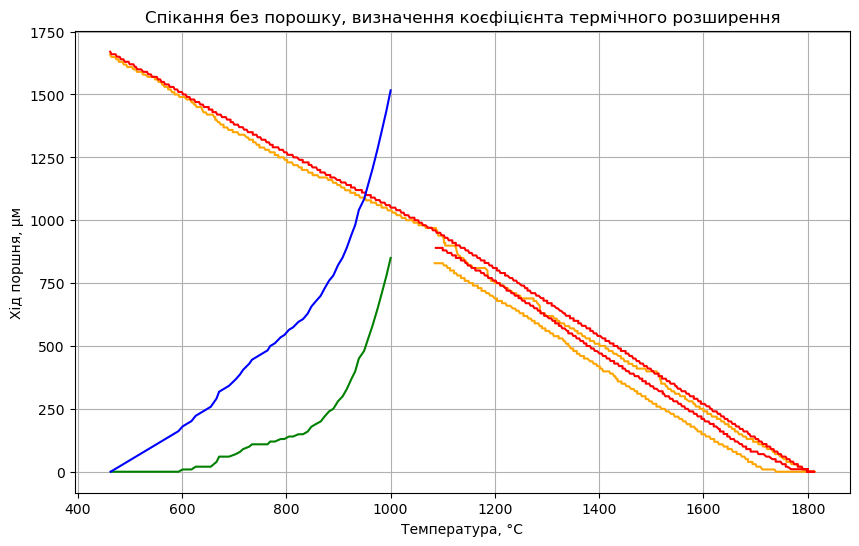

In [395]:
plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots( figsize=(10, 6))
ax1.plot(dataEmpty1['Pyrometer'], dataEmpty1['TravelRelative'], color='orange') 
ax1.plot(dataEmpty2['Pyrometer'], dataEmpty2['TravelRelative'], color='red') 

minTemperature = data1000['Pyrometer'].min()
data1000['TravelRelative2']=data1000['TravelRelative']+(data1000['Pyrometer']-minTemperature)*1.241
sc = ax1.plot(data1000['Pyrometer'], data1000['TravelRelative'], color='green') 
sc = ax1.plot(data1000['Pyrometer'], data1000['TravelRelative2'], color='blue') 


#minTemperature = data1200['Pyrometer'].min()
#data1200['TravelRelative2']=data1200['TravelRelative']+(data1200['Pyrometer']-minTemperature)*1.241
#sc = ax1.plot(data1200['Pyrometer'], data1200['TravelRelative'], color='green') 
#sc = ax1.plot(data1200['Pyrometer'], data1200['TravelRelative2'], color='blue') 

#sc = plt.scatter(setToPlot['seconds'], setToPlot['Pyrometer'],color='red')  
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Heating'], color='green') 
# Add color bar to show the color scale
ax1.set_ylabel('Хід поршня, μм')
#ax1.set_ylim(400, 1000)
#ax1.set_xlim(300, 1400)
ax1.set_title('Спікання без порошку, визначення коєфіцієнта термічного розширення')
ax1.set_xlabel('Температура, °C')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

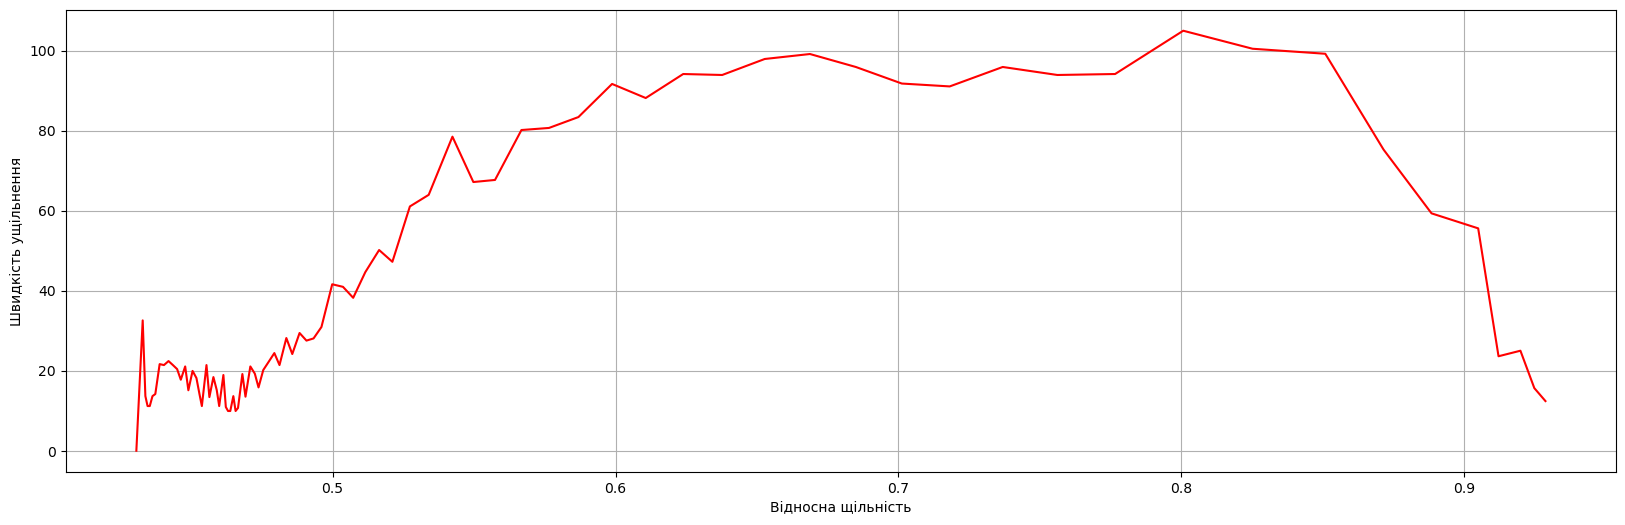

In [168]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(20, 6))
#sc = ax1.plot(data900['seconds'], data900['Pyrometer'], color='red') 
#sc = ax1.plot(data1000['seconds'], data1000['Pyrometer'], color='red') 
#sc = ax1.plot(data1000['seconds'], data1000['Density'], color='green')
#sc = ax1.plot(data1200['seconds'], data1200['Density'], color='red')
#sc = ax1.plot(data1000['Density'], data1000['TravelDelta'], color='green')
#sc = ax1.plot(data900['Density'], data900['TravelDelta'], color='black')
sc = ax1.plot(data1200['Density'], data1200['TravelDelta'], color='red')
#sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrected'], color='blue') 
#sc = ax1.plot(data1200['seconds'], data1200['Pyrometer'], color='green') 
#sc = ax1.plot(data1350['seconds'], data1350['Pyrometer'], color='black') 
#sc = ax1.plot(dataN1200['seconds'], dataN1200['Pyrometer'], color='purple') 
#sc = ax1.plot(dataN1100['seconds'], dataN1100['Pyrometer'], color='orange') 
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Pyrometer'],color='red')  
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Heating'], color='green') 
# Add color bar to show the color scale
ax1.set_ylabel('Швидкість ущільнення')
#ax1.set_ylim(400, 1000)
#ax1.set_xlim(300, 1400)
#ax1.set_title('title')
ax1.set_xlabel('Відносна щільність')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

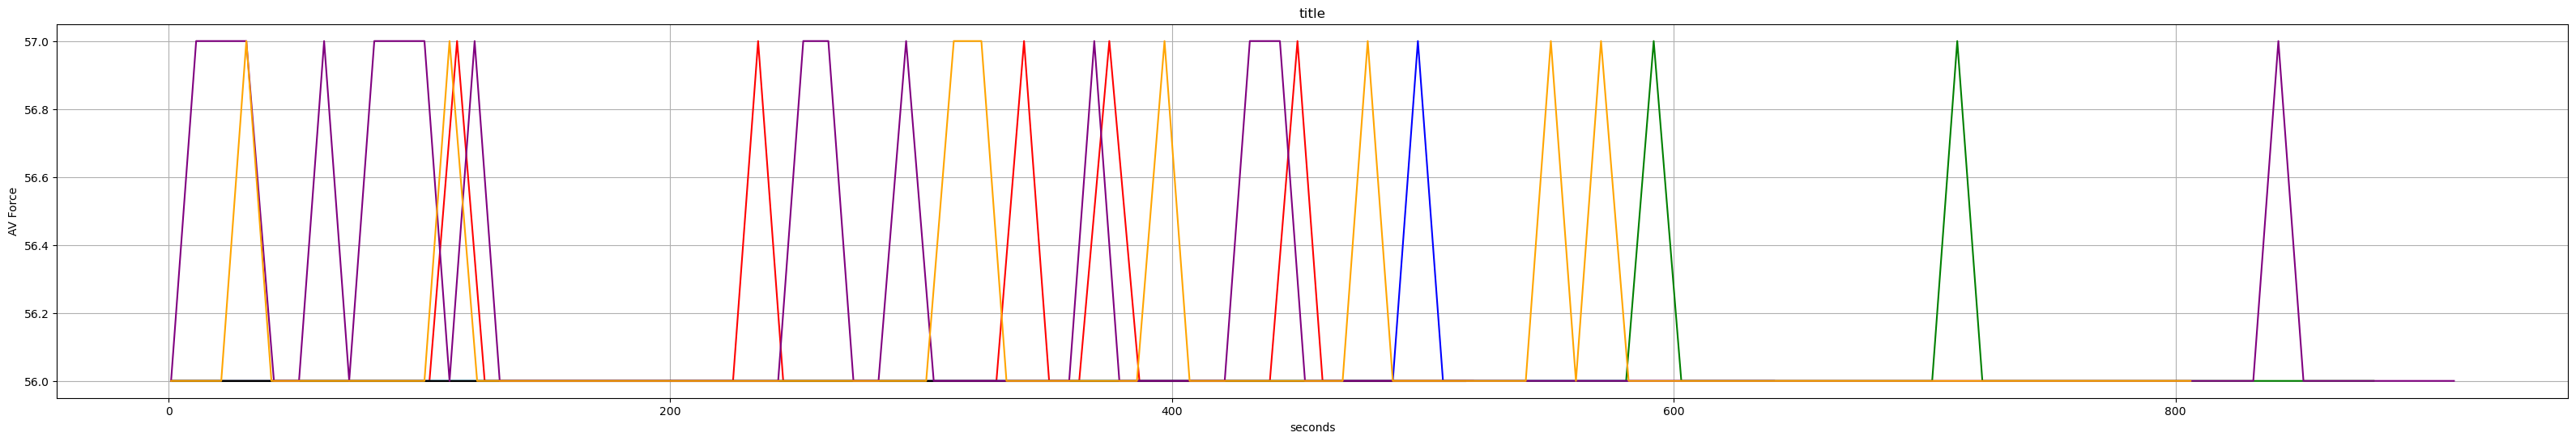

In [161]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(40, 6))
sc = ax1.plot(data900['seconds'], data900['AV Force'], color='red') 
sc = ax1.plot(data1000['seconds'], data1000['AV Force'], color='blue') 
sc = ax1.plot(data1200['seconds'], data1200['AV Force'], color='green') 
sc = ax1.plot(data1350['seconds'], data1350['AV Force'], color='black') 
sc = ax1.plot(dataN1200['seconds'], dataN1200['AV Force'], color='purple') 
sc = ax1.plot(dataN1100['seconds'], dataN1100['AV Force'], color='orange') 
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Pyrometer'],color='red')  
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Heating'], color='green') 
# Add color bar to show the color scale
ax1.set_ylabel('AV Force')
#ax1.set_ylim(400, 1000)
#ax1.set_xlim(300, 1400)
ax1.set_title('title')
ax1.set_xlabel('seconds')
ax1.grid(True)
plt.show()

<Figure size 2000x600 with 0 Axes>

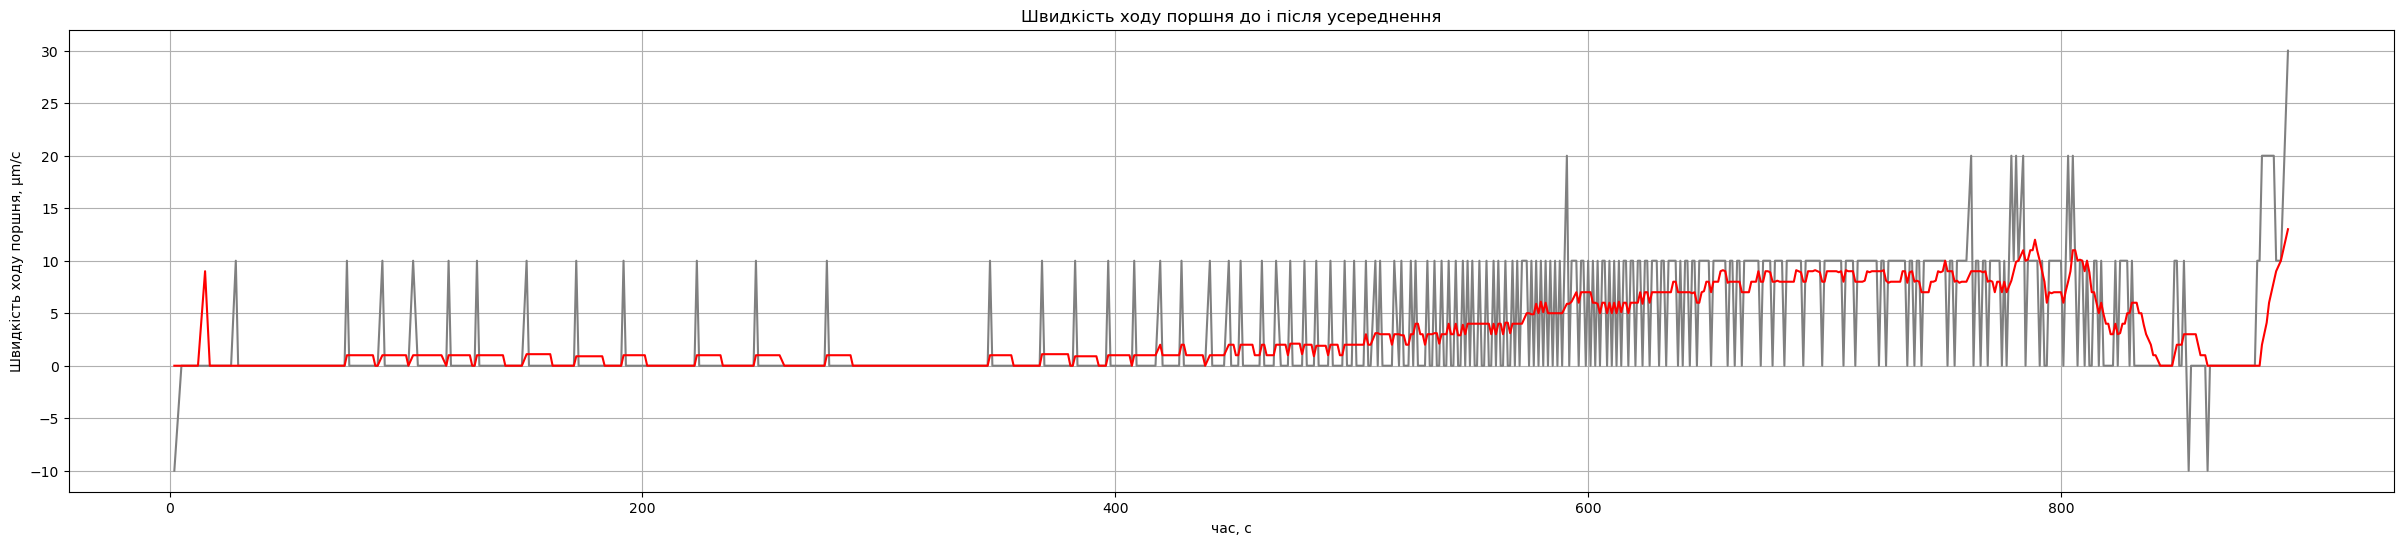

In [435]:

plt.figure(figsize=(20, 6))
fig, ax1 = plt.subplots( figsize=(30, 6))
#sc = ax1.plot(data900['seconds'], data900['TravelDelta'], color='red')  
#sc = ax1.plot(data1000['seconds'], data1000['TravelDelta'], color='green') 
sc = ax1.plot(data1200['seconds'], data1200['TravelDeltaOriginal']*1000, color='gray') 
sc = ax1.plot(data1200['seconds'], data1200['TravelDelta2'], color='red') 

##sc = ax1.plot(data1200['seconds'], data1200['TravelDelta'], color='green') 
#sc = ax1.plot(dataN1200['seconds'], dataN1200['TravelDelta'], color='purple') 
#sc = ax1.plot(dataN1100['seconds'], dataN1100['TravelDelta'], color='orange') 
#sc = ax1.plot(data1350['seconds'], data1350['TravelDelta'], color='black') 
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Pyrometer'],color='red')  
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Heating'], color='green') 
# Add color bar to show the color scale
ax1.set_ylabel('Швидкість ходу поршня, μm/с')
#ax1.set_ylim(400, 1000)
#ax1.set_xlim(300, 1400)
ax1.set_title('Швидкість ходу поршня до і після усереднення')
ax1.set_xlabel('час, с')
ax1.grid(True)
plt.show()

In [ ]:
def plot_data_Travel(data, title):
    setToPlot = data.copy()
    #setToPlot = setToPlot[(setToPlot['seconds'] > 0) & (setToPlot['seconds'] <650)].copy()
    #setToPlot = setToPlot[(setToPlot['Heating'] > 0)].copy()

    #setToPlot = setToPlot[(setToPlot['Pyrometer'] < 900)].copy()
    #setToPlot = setToPlot[(setToPlot['seconds'] < 850)].copy()
    plt.figure(figsize=(40, 6))
    fig, ax1 = plt.subplots( figsize=(40, 6))
    sc2 = ax1.plot(setToPlot['seconds'], setToPlot['TravelRelative'], color='red')
    sc2 = ax1.plot(setToPlot['seconds'], setToPlot['TravelRelative'], color='red')
    TravelDeltaOriginal
    #sc2 = ax1.plot(setToPlot['seconds'], setToPlot['TravelRelativeCorrected'], color='green')
    #sc2 = ax1.plot(setToPlot['seconds'], setToPlot['TravelRelativeCorrectedShifted'], color='blue')
    sc2 = ax1.plot(setToPlot['seconds'], setToPlot['TravelRelativeTempCorrected'], color='orange')

    
    ax1.set_ylabel('TrevelRelative')
    #ax1.set_ylim(0, 800)
    #ax1.set_ylim(0, 4000)
    ax1.set_title(title)
    ax1.set_xlabel('seconds')
    ax1.grid(True)
    plt.show()

<Figure size 4000x600 with 0 Axes>

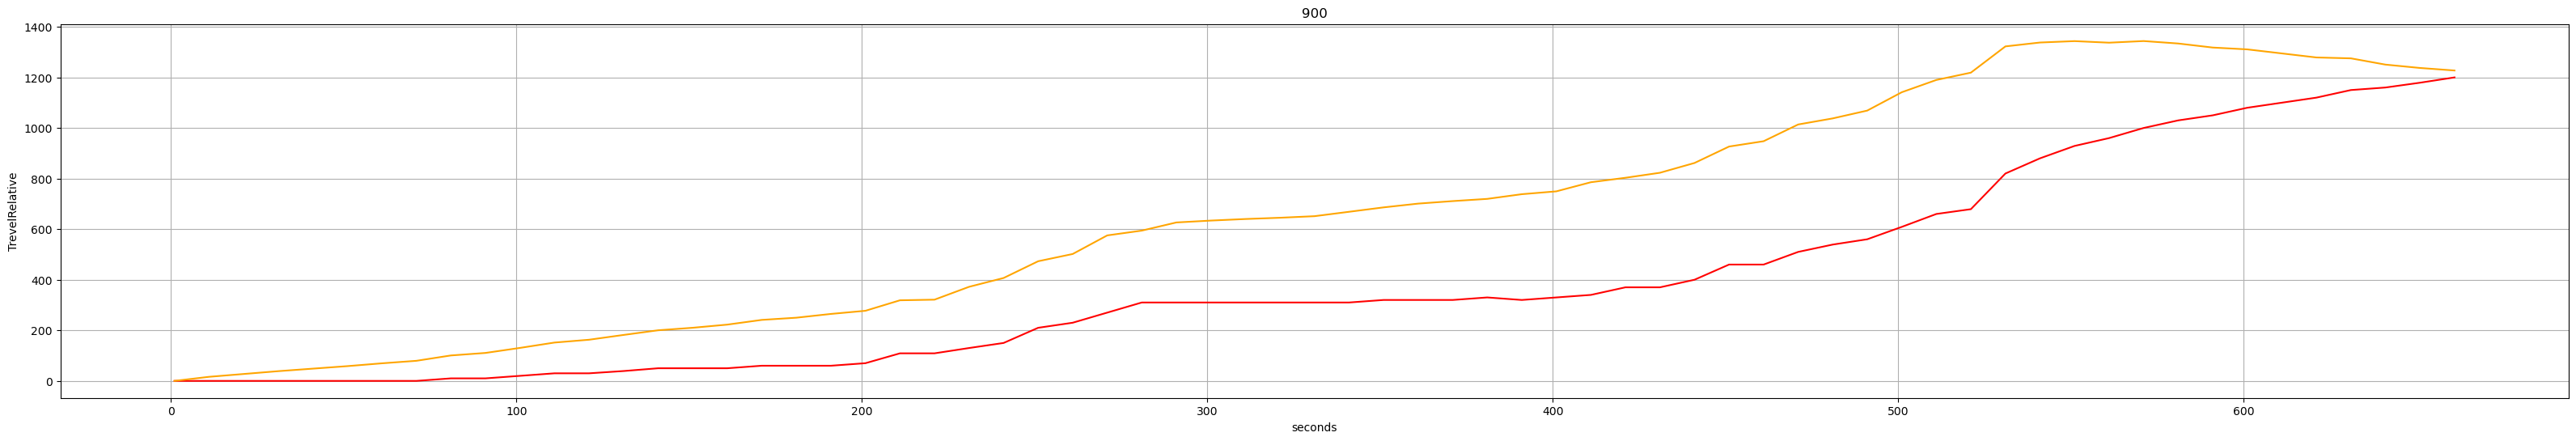

<Figure size 4000x600 with 0 Axes>

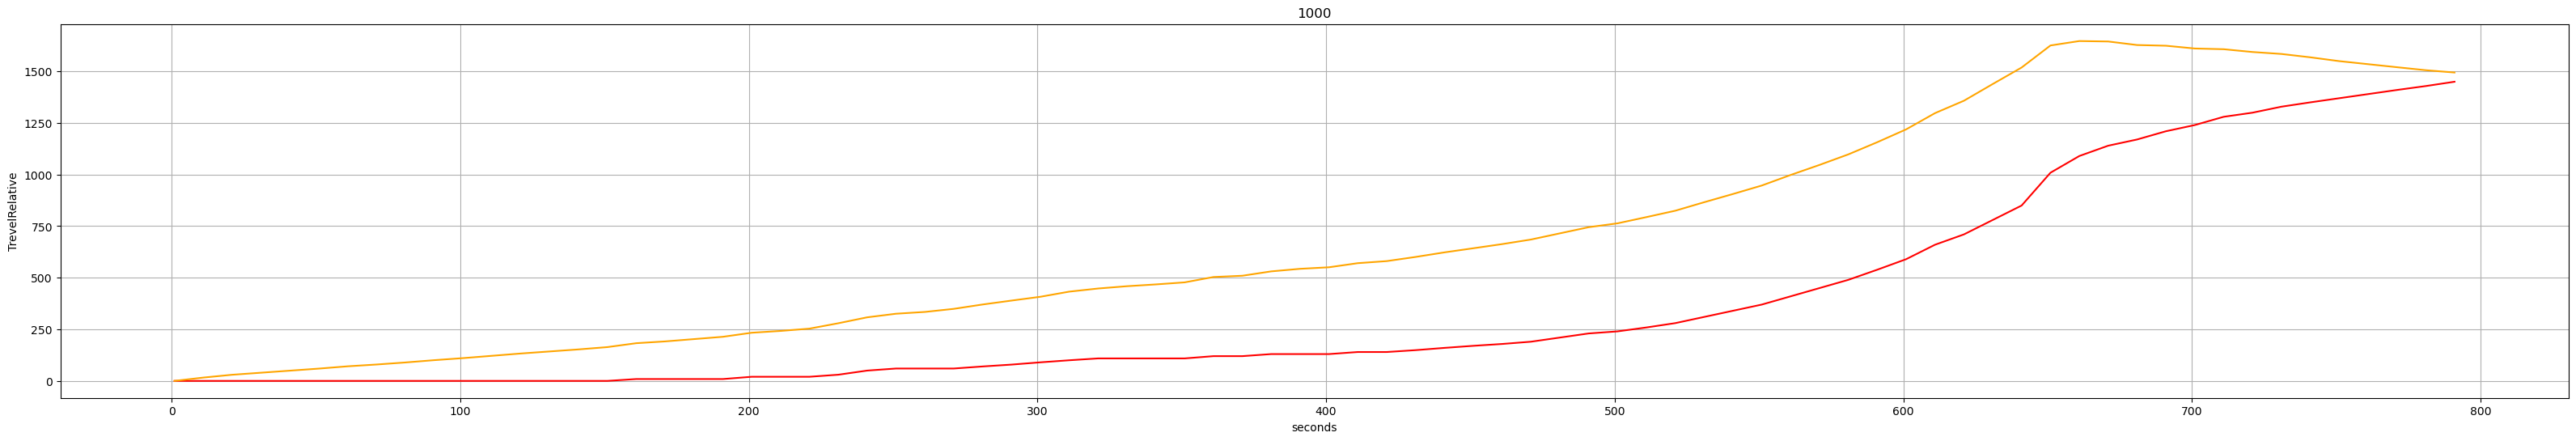

<Figure size 4000x600 with 0 Axes>

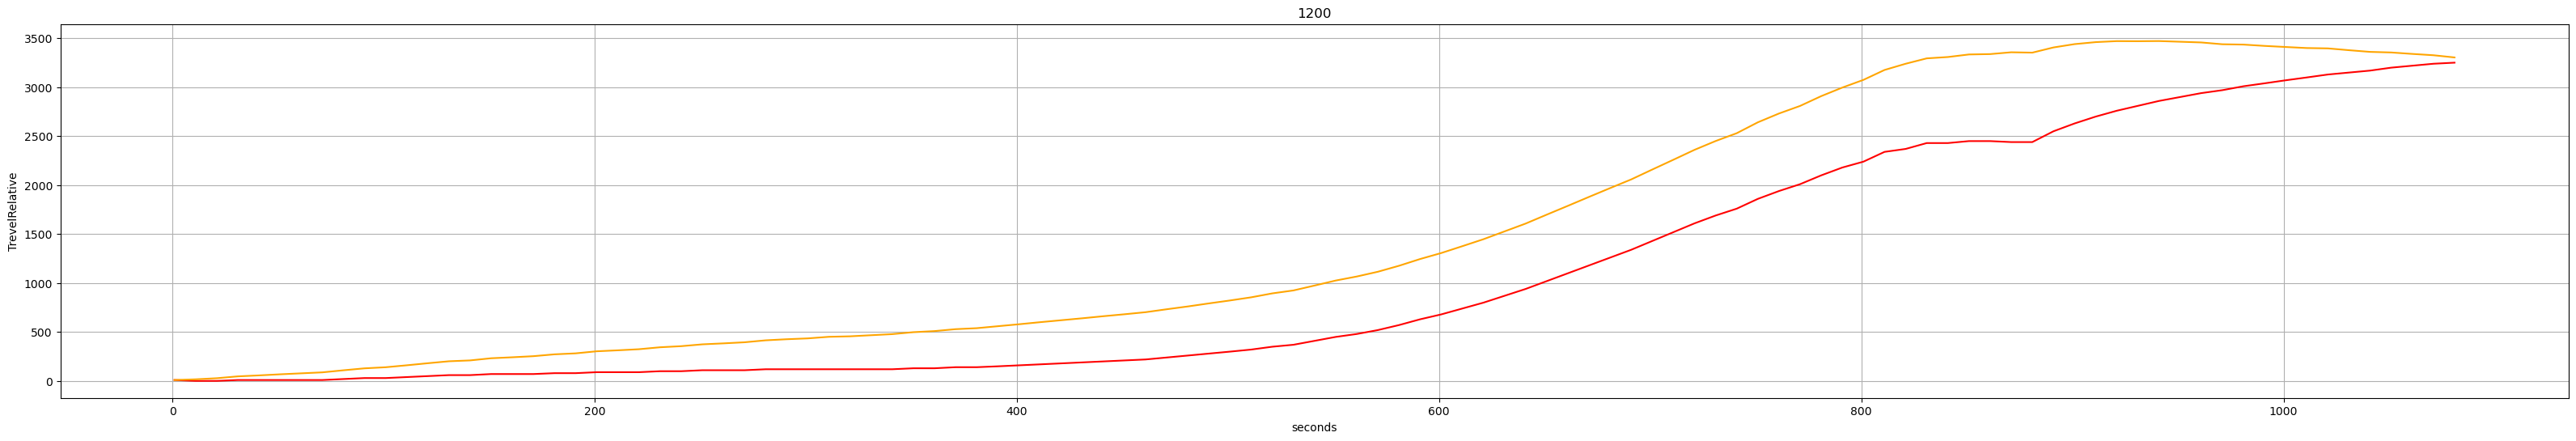

<Figure size 4000x600 with 0 Axes>

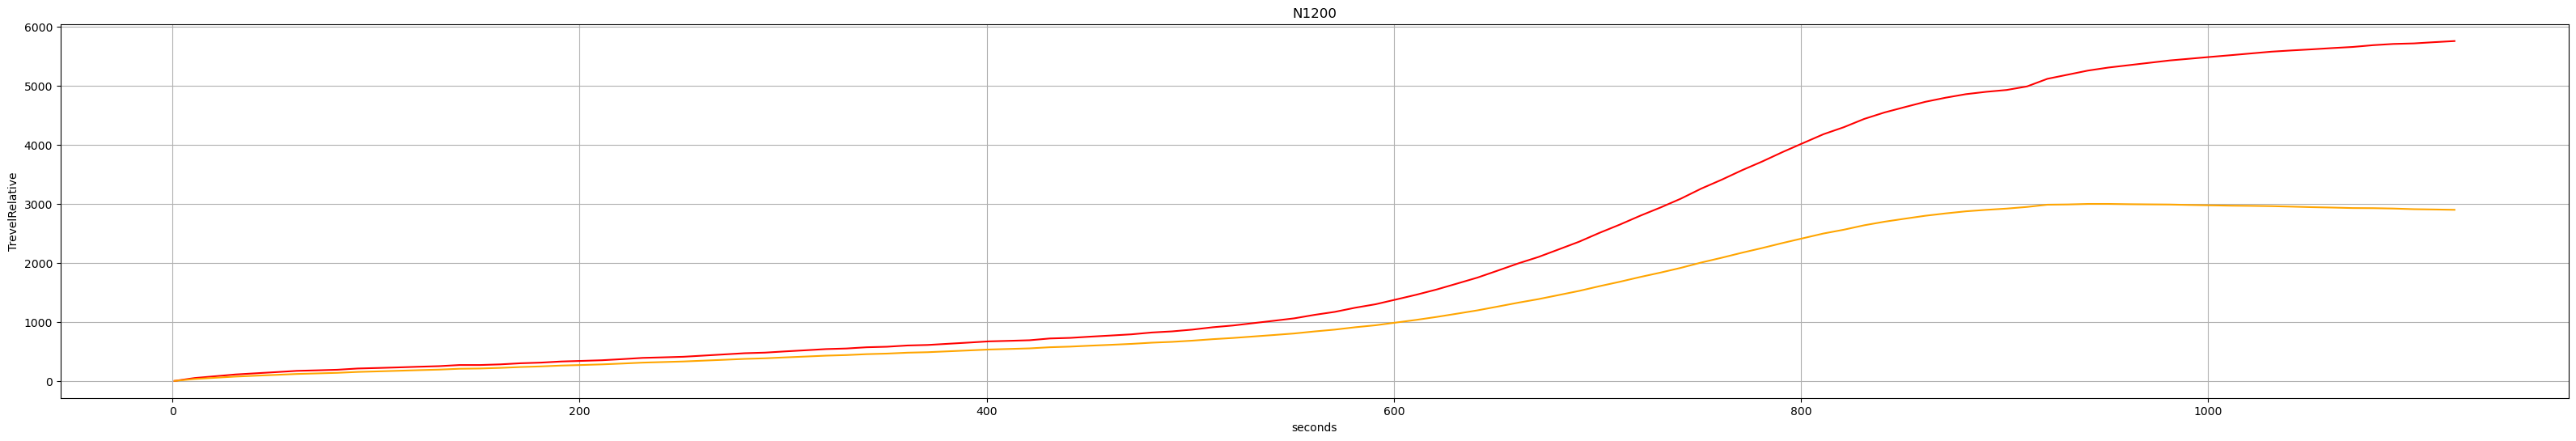

In [16]:
plot_data_Travel(data900, '900')
plot_data_Travel(data1000, '1000')
plot_data_Travel(data1200, '1200')
plot_data_Travel(dataN1200, 'N1200')
#plot_data_Travel(dataN1100, 'N1100')
#plot_data_Travel(data1350, '1350')

In [34]:
def plot_data_TravelDelta(data, title):
    setToPlot = data.copy()
    #setToPlot = setToPlot[(setToPlot['seconds'] > 0) & (setToPlot['seconds'] <650)].copy()
    #setToPlot = setToPlot[(setToPlot['Heating'] > 0)].copy()

    #setToPlot = setToPlot[(setToPlot['Pyrometer'] < 900)].copy()
    #setToPlot = setToPlot[(setToPlot['seconds'] < 850)].copy()

    # setToPlot['Heating'] = (setToPlot['Heating']*10).astype(int)
    plt.figure(figsize=(40, 6))
    fig, ax1 = plt.subplots( figsize=(40, 6))
    sc = ax1.plot(setToPlot['Pyrometer'], setToPlot['TravelDelta'], color='red')  
    #sc = ax1.plot(setToPlot['seconds'], setToPlot['TravelRelativeTempCorrectedShifted'], color='red')  
    #sc = ax1.plot(setToPlot['seconds'], setToPlot['TravelDelta'], color='green')  
    #sc = ax1.plot(setToPlot['Pyrometer'], setToPlot['AV Force']*10, color='blue')  
    # sc = ax1.plot(setToPlot['seconds'], setToPlot['Heating']) 
    #sc = plt.scatter(setToPlot['seconds'], setToPlot['Pyrometer'],color='red')  
    #sc = plt.scatter(setToPlot['seconds'], setToPlot['Heating'], color='green') 
    # ax2 = ax1.twinx()
    # sc2 = ax2.plot(setToPlot['seconds'], setToPlot['TravelDelta'], color='green')
    # Add color bar to show the color scale
    # ax2.set_ylim(0, 10)
    # ax2.set_ylabel('TravelDelta')
    ax1.set_ylabel('seconds, TravelDelta')
    # ax1.set_ylim(400, 1000)
    # ax1.set_xlim(300, 1400)
    # ax2.set_xlim(300, 1400)
    ax1.set_title(title)
    ax1.set_xlabel('seconds')
    ax1.grid(True)
    plt.show()

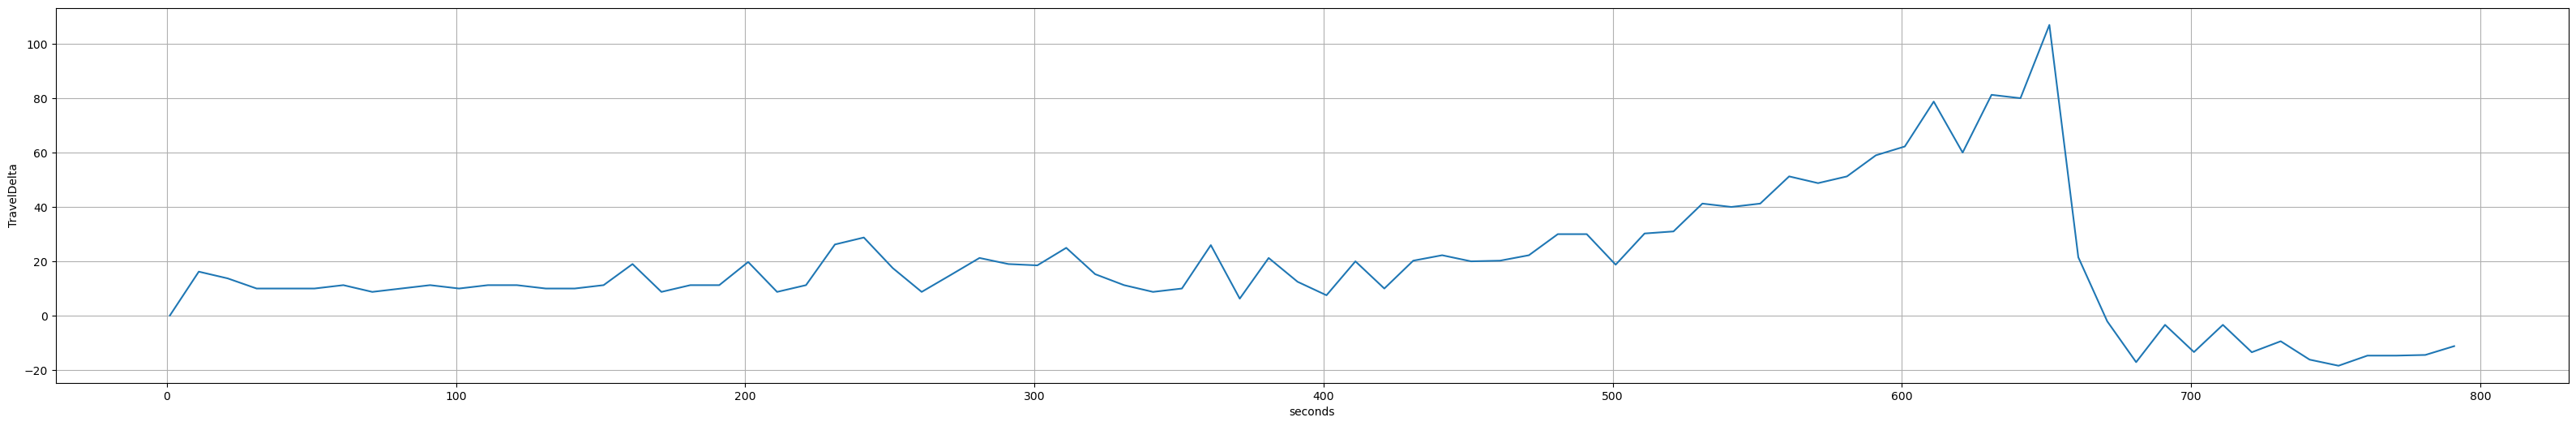

In [50]:
setToPlot = data1000
#setToPlot = setToPlot[(setToPlot['seconds'] > 550) & (setToPlot['seconds'] <650)].copy()
 

plt.figure(figsize=(40, 6))
#sc = plt.scatter(setToPlot['seconds'], setToPlot['TravelDelta'], c=setToPlot['Pyrometer'], cmap='viridis')  
sc = plt.plot(setToPlot['seconds'], setToPlot['TravelDelta'])  

# Add color bar to show the color scale
#plt.colorbar(sc, label='Temperature')
#plt.title('-')
plt.xlabel('seconds')
plt.ylabel('TravelDelta')
plt.grid(True)
plt.show()

#setToPlot.head(50)

<Figure size 4000x600 with 0 Axes>

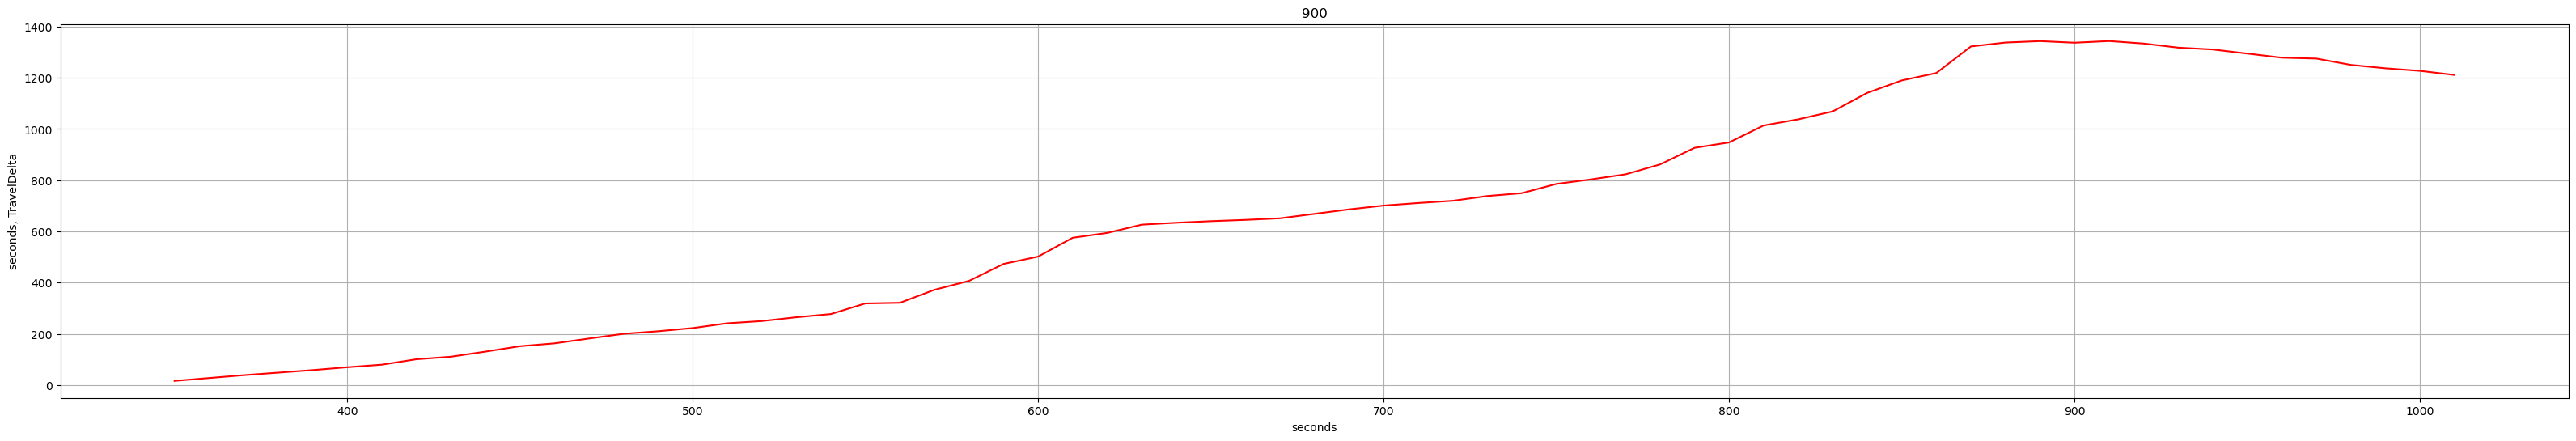

<Figure size 4000x600 with 0 Axes>

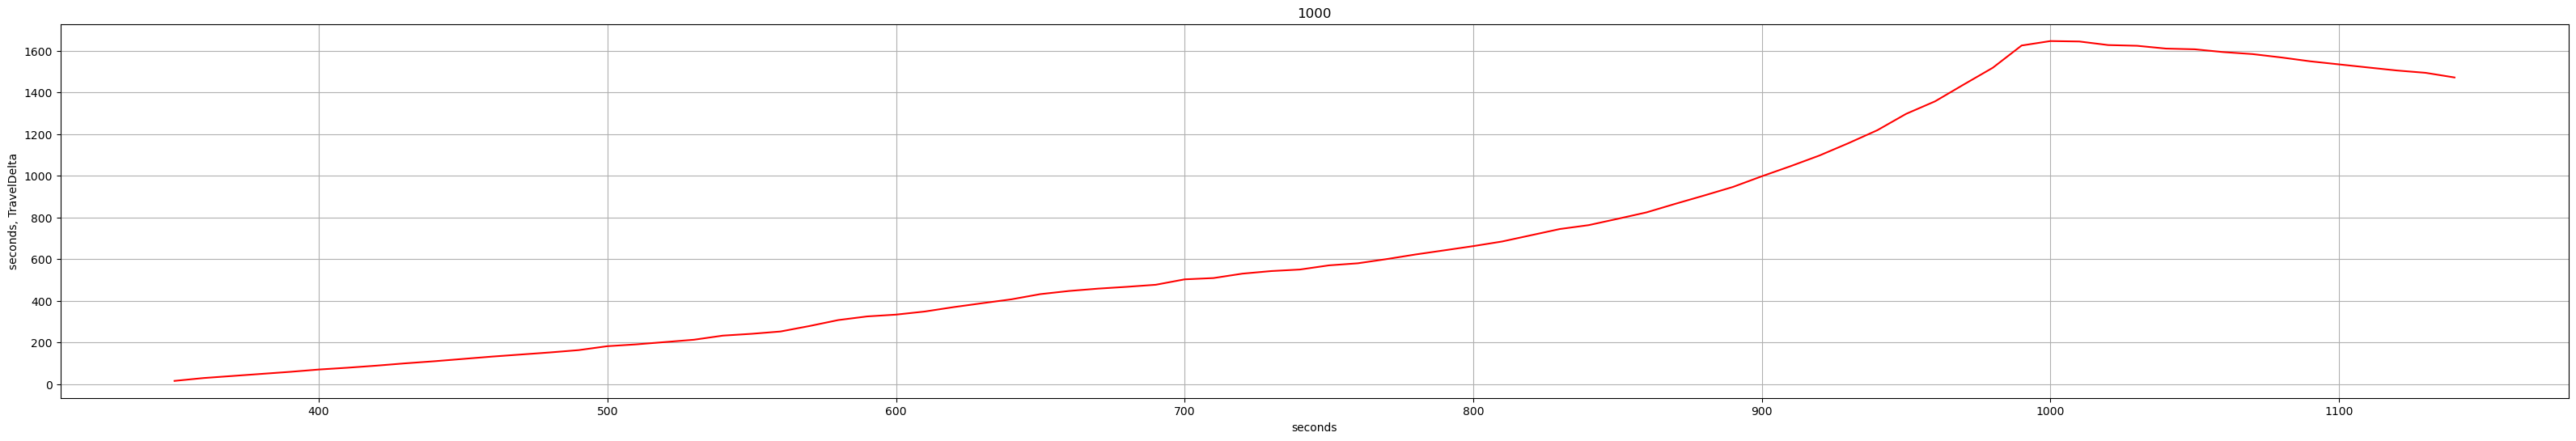

<Figure size 4000x600 with 0 Axes>

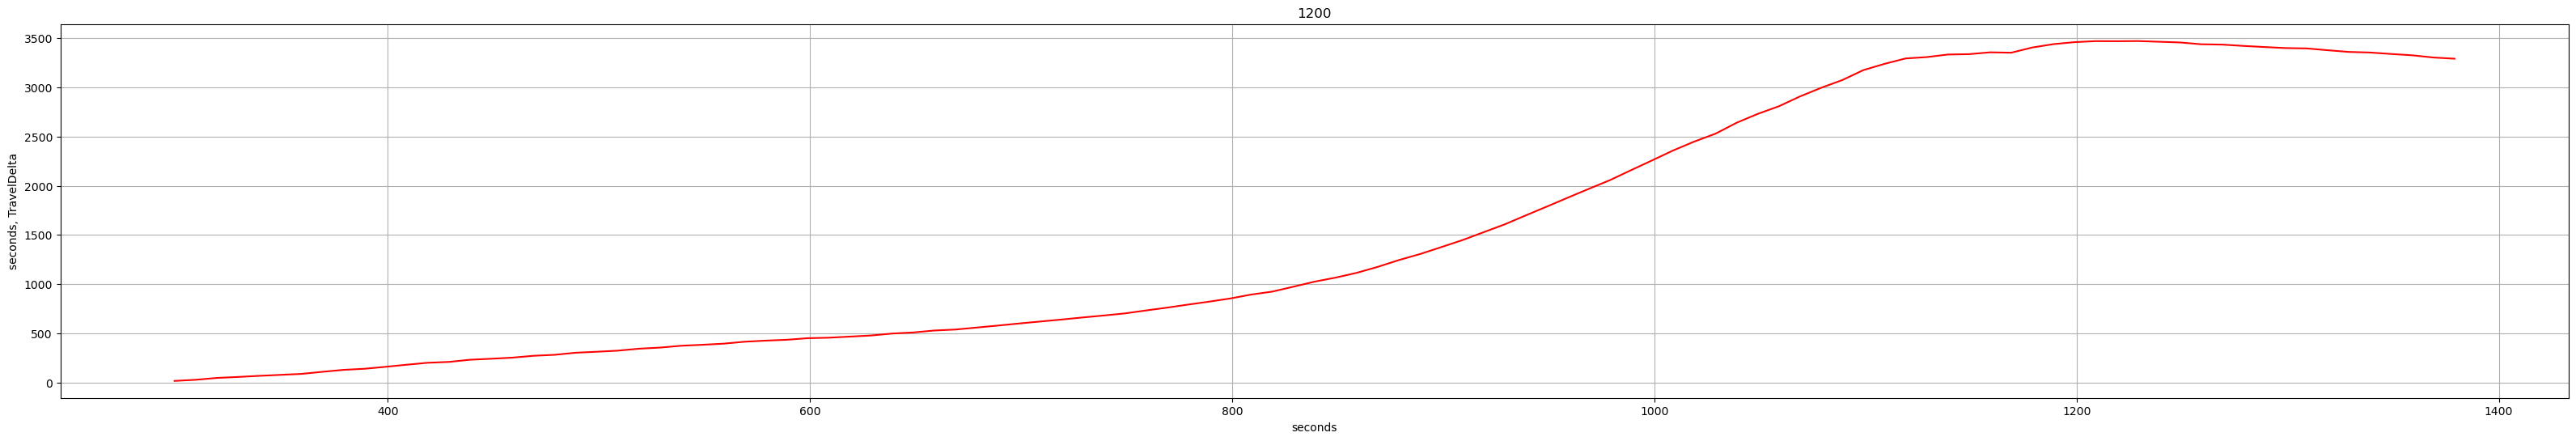

<Figure size 4000x600 with 0 Axes>

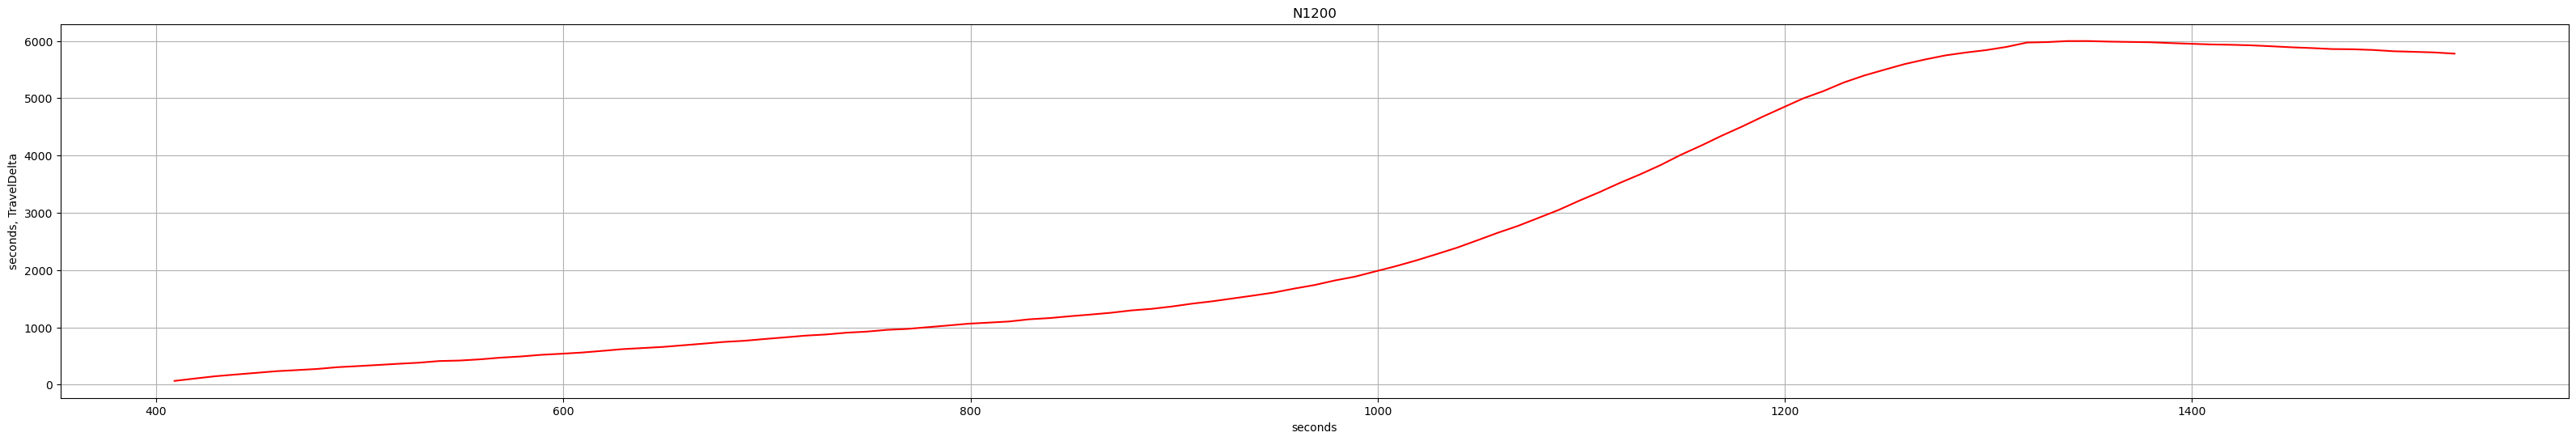

<Figure size 4000x600 with 0 Axes>

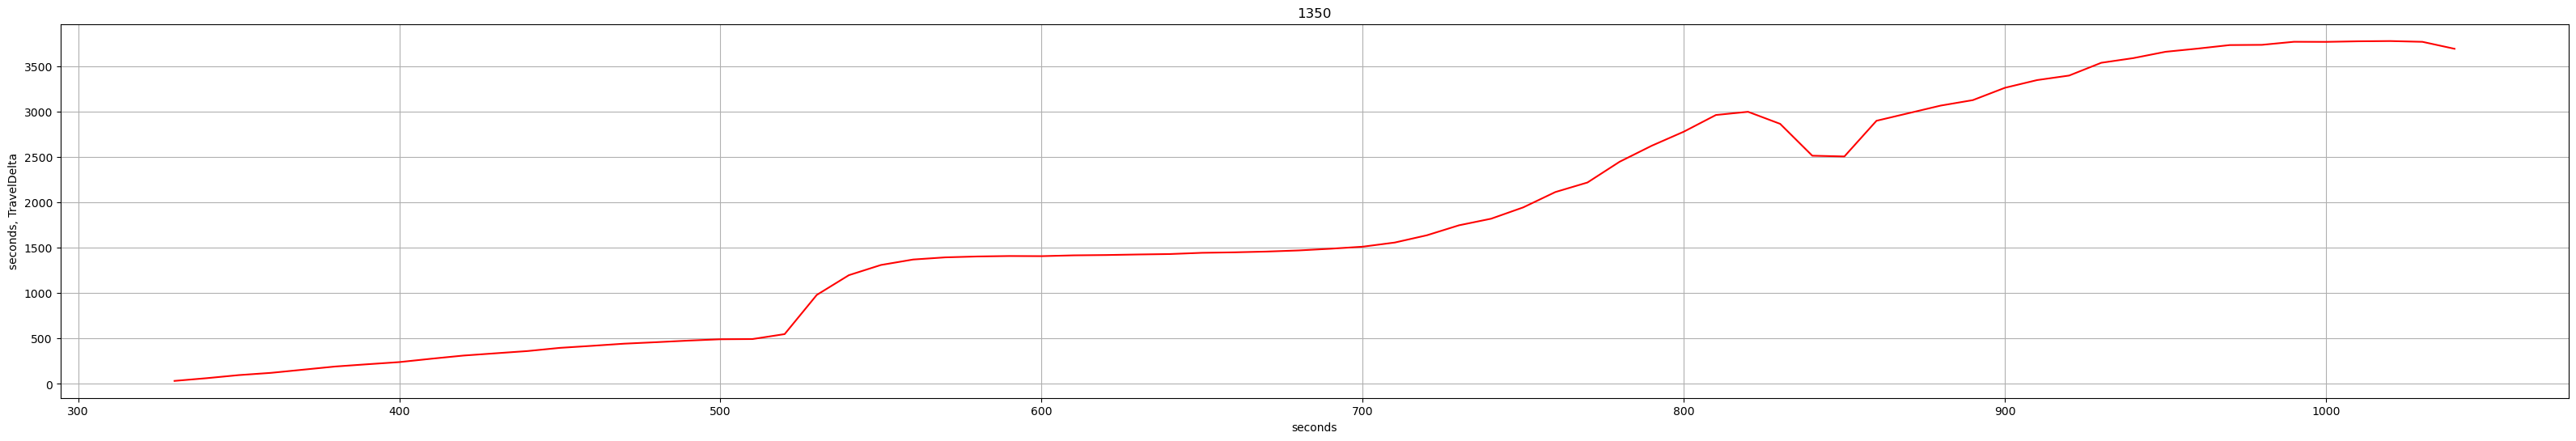

In [94]:
plot_data_TravelDelta(data900, '900')
plot_data_TravelDelta(data1000, '1000')
plot_data_TravelDelta(data1200, '1200')
plot_data_TravelDelta(dataN1200, 'N1200')
plot_data_TravelDelta(data1350, '1350')


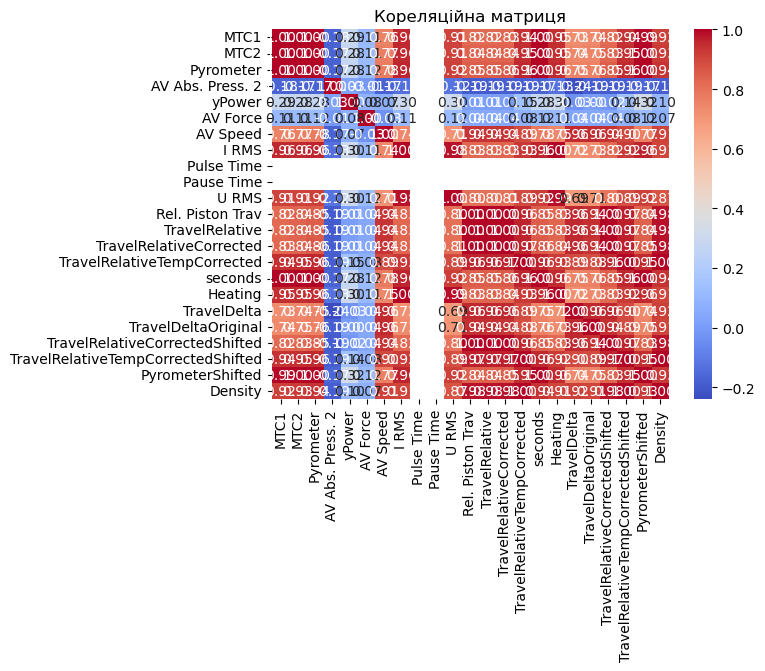

In [ ]:
import seaborn as sns
#data1000.corr()
selected_columns = ['Pyrometer', '', 'column3']
new_df = data1000[selected_columns].copy()
corr_matrix = new_df.corr()

# Побудова теплової карти
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Кореляційна матриця")
plt.show()


In [24]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Select the relevant columns
X = pd.concat( [data900,data1000,data1200], axis=0)
y = pd.concat( [data900,data1000,data1200], axis=0)

X = X[['seconds','Heating', 'Pyrometer', 'AV Force']]
y = y['TravelRelativeCorrected']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the kernel for the GPR model
kernels = [
    C(1.0, (1e-4, 1e1)) * RBF(length_scale=1.0),
    C(1.0, (1e-4, 1e1)) * Matern(length_scale=1.0, nu=1.5),
    C(1.0, (1e-4, 1e1)) * RationalQuadratic(length_scale=1.0, alpha=0.1),
    C(1.0, (1e-4, 1e1)) * ExpSineSquared(length_scale=1.0, periodicity=3.0),
    C(1.0, (1e-4, 1e1)) * DotProduct(sigma_0=1.0)
]
kernel = kernels[0]

# Create and train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
gpr.fit(X_train, y_train)

# Make predictions
y_pred = gpr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Print the kernel parameters
print(f'Kernel parameters: {gpr.kernel_}')

Mean Squared Error: 362971.59455775766
Kernel parameters: 3.16**2 * RBF(length_scale=9.91)


c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [208]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# data1000 
# data900 
# data1350 -- bad data
# data1200 
# dataN1200 -- Different rate?
# dataN1100 -- bad data?

# data1000 = data1000.sort_values(by=['seconds'])
# data900 = data900.sort_values(by=['seconds'])
# data1200 = data1200.sort_values(by=['seconds'])
# data1350 = data1350.sort_values(by=['seconds'])
# dataN1200 = dataN1200.sort_values(by=['seconds'])
# dataN1100 = dataN1100.sort_values(by=['seconds'])

# Select the relevant columns
#D = pd.concat( [data900, data1000, data1200, data1350,dataN1200,dataN1100], axis=0)
D = pd.concat( [data900, data1000, data1200,dataN1200], axis=0)
#D = pd.concat( [data900, data1000,dataN1200], axis=0)
#D = pd.concat( [data900, data1000, data1200], axis=0)

#TravelRelativeCorrectedShifted

#X_train = X[['seconds','Heating', 'Pyrometer', 'AV Force']]
X_train = D[['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted']]
#X_train = X[['seconds','Heating', 'Pyrometer']]
y_train = D['TravelRelativeTempCorrectedShifted']

 # Define the kernel for the GPR model
kernels = [
    C(1.0, (1e-4, 1e9)) * RBF(length_scale=1.0),
    C(1.0, (1e-4, 1e9)) * Matern(length_scale=1.0, nu=1.5),
    C(1.0, (1e-4, 1e9)) * RationalQuadratic(length_scale=1.0, alpha=0.1),
    C(1.0, (1e-4, 1e9)) * ExpSineSquared(length_scale=1.0, periodicity=3.0),
    C(1.0, (1e-4, 1e9)) * DotProduct(sigma_0=1.0)
]
kernel = kernels[4]

# Create and train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=1e-3)
gpr.fit(X_train, y_train)

# Make predictions

#X_test = data1000[['seconds','Heating', 'Pyrometer', 'AV Force']]
X_test = dataN1200[['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted']]
#X_test = data1000[['seconds','Heating', 'Pyrometer']]
y_test = dataN1200['TravelRelativeTempCorrectedShifted']

y_pred = gpr.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Print the kernel parameters
print(f'Kernel parameters: {gpr.kernel_}')

c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Mean Squared Error: 258.8263564472225
Kernel parameters: 70.3**2 * DotProduct(sigma_0=11)


<Figure size 1500x600 with 0 Axes>

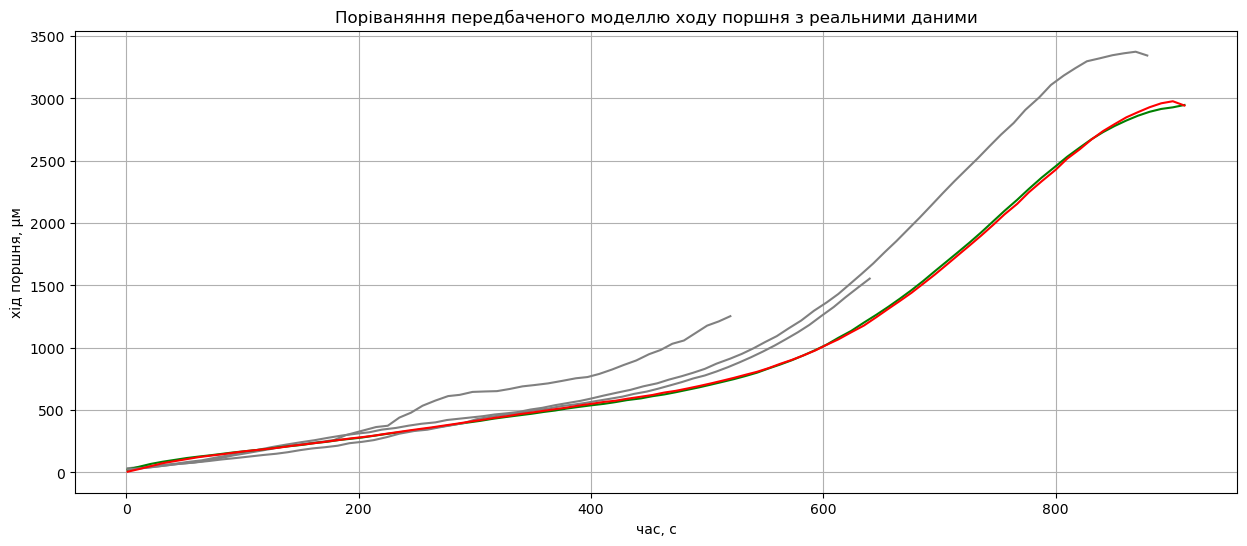

In [377]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

sc = ax1.plot(data1200['seconds'], data1200['TravelRelativeTempCorrectedShifted'], color='grey') 
#sc = ax1.plot(data1350['seconds'], data1350['TravelRelativeTempCorrectedShifted'], color='grey') 
#sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(data900['seconds'], data900['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(dataN1200['seconds'], dataN1200['TravelRelativeTempCorrectedShifted'], color='green') 
sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(X_test['seconds'], y_pred, color='red') 
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Pyrometer'],color='red')  
#sc = plt.scatter(setToPlot['seconds'], setToPlot['Heating'], color='green') 
# Add color bar to show the color scale
#ax1.set_ylabel('Pyrometer, Heating')
#ax1.set_ylim(400, 1000)
#ax1.set_xlim(300, 1400)
ax1.set_title('Поріваняння передбаченого моделлю ходу поршня з реальними даними')
ax1.set_xlabel('час, с')
ax1.set_ylabel('хід поршня, μм')
ax1.grid(True)
plt.show()

In [371]:

PredictionSet = data1000.head(1)
PredictionSet = PredictionSet[['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted']]
PredictionSet = PredictionSet.reset_index(drop=True)
time = PredictionSet['seconds'].iloc[0]

newRegime = PredictionSet.copy()

heating = 1

print(PredictionSet)
while time < 4000 and ( heating == 1 or PredictionSet['PyrometerShifted'].iloc[0] > 1000) :
     TravelRelativeTempCorrectedPredicted = gpr.predict(PredictionSet, return_std=True); 
     #print(TravelRelativeTempCorrectedPredicted[0][0])
     if PredictionSet['PyrometerShifted'].iloc[0] > 1200:
           heating = 0
     time = time + 10
     PredictionSet.loc[0,'seconds'] = time
     PredictionSet.loc[0,'TravelRelativeTempCorrected'] = TravelRelativeTempCorrectedPredicted[0][0]
     PredictionSet.loc[0,'Pyrometer'] = PredictionSet['PyrometerShifted'].iloc[0]
     if heating:
          PredictionSet.loc[0,'PyrometerShifted'] = PredictionSet['PyrometerShifted'].iloc[0] + 8
     else:
          PredictionSet.loc[0,'PyrometerShifted'] = PredictionSet['PyrometerShifted'].iloc[0] -30
     #print(PredictionSet)
     newRegime = pd.concat([newRegime, PredictionSet], ignore_index=True)
     newRegime.at[newRegime.index[-1],'STD'] = TravelRelativeTempCorrectedPredicted[1][0]
#newRegime.head(100)

   seconds  TravelRelativeTempCorrected  Pyrometer  PyrometerShifted
0        1                          0.0        463             482.0


In [348]:
def calulate_TargetDensificationRateValue(value):
    if value < 0.40:
        return 1
    elif 0.40 <= value < 0.70:
        # Лінійне зростання від 0 до 110
        return ((value - 0.40) / (0.70 - 0.40) * 110)+1

    elif 0.70 <= value < 0.85:
        return 50
    elif 0.85 <= value < 0.97:
        # Лінійне зменшення від 50 до 0
        return (0.97 - value) / (0.97 - 0.85) * 50
    else:
        return 0

def calulate_TargetDensificationRate(column):
    result = []
    for value in column:
        result.append(calulate_TargetDensificationRateValue(value))
    return pd.Series(result, index=column.index)

def find_closest_index(column, target_value):
    squared_diff = (column - target_value) ** 2
    return squared_diff.idxmin()

#calulate_TargetDensificationRate(0.45)


In [437]:


PredictionSet = data1000.head(1)
PredictionSet = PredictionSet[['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted']]
PredictionSet = PredictionSet.reset_index(drop=True)
time = PredictionSet['seconds'].iloc[0]
numberOfOptions = 60
newRegime = PredictionSet.copy()
for i in range(0, numberOfOptions):
     PredictionSet = pd.concat([newRegime]*numberOfOptions, ignore_index=True)
heating = 1
#print(newRegime)

density=0
time = time + 10
for i in range(0, numberOfOptions):
     PredictionSet.loc[i,'seconds'] = time
     PredictionSet.loc[i,'PyrometerShifted'] = PredictionSet['PyrometerShifted'].iloc[i] + i-5

#print(PredictionSet)
while time < 1000 and (density<0.96 ) :
     
     TravelRelativeTempCorrectedPredicted = gpr.predict(PredictionSet, return_std=True); 
     #print(TravelRelativeTempCorrectedPredicted[0][0])
     #select best prediction
     
     densificationRate = ( TravelRelativeTempCorrectedPredicted[0]-PredictionSet['TravelRelativeTempCorrected'])/10/1000
     density = calulate_density(PredictionSet['TravelRelativeTempCorrected'].iloc[0])
     targetRate = calulate_TargetDensificationRateValue(density)
     predictedRates = pd.Series(TravelRelativeTempCorrectedPredicted[0]-PredictionSet.loc[0,'TravelRelativeTempCorrected'])
     #print(predictedRates)
     bestIndex = find_closest_index(predictedRates, targetRate)
     #print(targetRate)
     #print(bestIndex)
     time = time + 10
     for i in range(0, numberOfOptions):
          PredictionSet.loc[i,'seconds'] = time
          PredictionSet.loc[i,'TravelRelativeTempCorrected'] = TravelRelativeTempCorrectedPredicted[0][bestIndex]
          PredictionSet.loc[i,'Pyrometer'] = PredictionSet['PyrometerShifted'].iloc[bestIndex]
          if heating:
               PredictionSet.loc[i,'PyrometerShifted'] = PredictionSet['PyrometerShifted'].iloc[bestIndex] + i-20
          else:
               PredictionSet.loc[i,'PyrometerShifted'] = PredictionSet['PyrometerShifted'].iloc[bestIndex] -30
     #print(PredictionSet)
     bestPrediction = PredictionSet.iloc[bestIndex]
     bestPrediction = pd.DataFrame([bestPrediction])
     #print(bestPrediction)
     newRegime = pd.concat([newRegime, bestPrediction], ignore_index=True)
     #print(newRegime)
     newRegime.at[newRegime.index[-1],'STD'] = TravelRelativeTempCorrectedPredicted[1][bestIndex]
newRegime.head(10)

c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
c:\Users\arros\miniconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted varia

,seconds,TravelRelativeTempCorrected,Pyrometer,PyrometerShifted,STD
0,1.0,0.0000,463.0,463.0,NaN
1,21.0,12.1875,492.0,506.0,0.006659
2,31.0,23.4375,506.0,520.0,0.003967
3,41.0,36.0000,518.0,530.0,0.004734
4,51.0,48.7500,527.0,536.0,0.005167
5,61.0,62.2500,535.0,543.0,0.004931
6,71.0,76.5000,543.0,551.0,0.004734
7,81.0,90.8750,550.0,557.0,0.004632
8,91.0,105.3750,557.0,564.0,0.005074
9,101.0,120.2500,564.0,571.0,0.004834


(-20.0, 40.0)

<Figure size 1500x600 with 0 Axes>

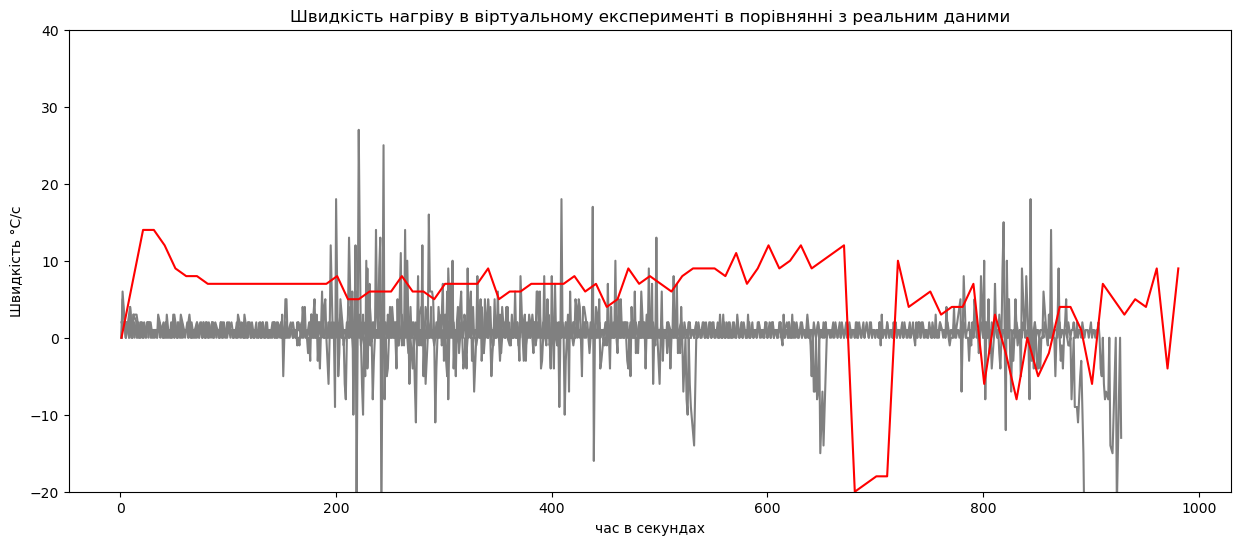

In [438]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))
#heating rate
sc = ax1.plot(data1200['seconds'], data1200['PyrometerShifted'] - data1200['Pyrometer'], color='gray') 
sc = ax1.plot(data900['seconds'], data900['PyrometerShifted'] - data900['Pyrometer'], color='gray') 
sc = ax1.plot(data1000['seconds'], data1000['PyrometerShifted'] - data1000['Pyrometer'], color='gray') 
sc = ax1.plot(dataN1200['seconds'], dataN1200['PyrometerShifted'] - dataN1200['Pyrometer'], color='gray') 
sc = ax1.plot(newRegime['seconds'], newRegime['PyrometerShifted'] - newRegime['Pyrometer'], color='red') 
ax1.set_title('Швидкість нагріву в віртуальному експерименті в порівнянні з реальним даними')
ax1.set_xlabel('час в секундах')
ax1.set_ylabel('Швидкість °C/c')
ax1.set_ylim(-20, 40 )

<Figure size 1500x600 with 0 Axes>

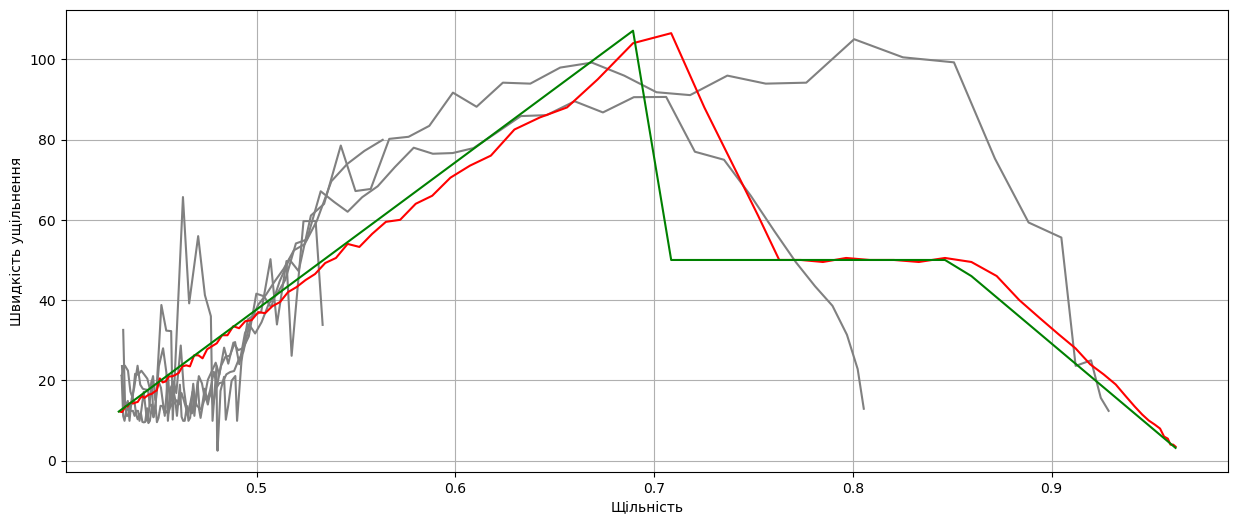

In [ ]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#densification rate
sc = ax1.plot( calulate_density(data1200['TravelRelativeTempCorrected']), data1200['TravelRelativeTempCorrected'] - data1200['TravelRelativeTempCorrected'].shift(1), color='grey')
sc = ax1.plot( calulate_density(data1000['TravelRelativeTempCorrected']), data1000['TravelRelativeTempCorrected'] - data1000['TravelRelativeTempCorrected'].shift(1), color='grey')
sc = ax1.plot( calulate_density(data900['TravelRelativeTempCorrected']), data900['TravelRelativeTempCorrected'] - data900['TravelRelativeTempCorrected'].shift(1), color='grey')
sc = ax1.plot( calulate_density(dataN1200['TravelRelativeTempCorrected']), dataN1200['TravelRelativeTempCorrected'] - dataN1200['TravelRelativeTempCorrected'].shift(1), color='grey')
sc = ax1.plot( calulate_density(newRegime['TravelRelativeTempCorrected']), newRegime['TravelRelativeTempCorrected'] - newRegime['TravelRelativeTempCorrected'].shift(1), color='red')
sc = ax1.plot( calulate_density(newRegime['TravelRelativeTempCorrected']), calulate_TargetDensificationRate(calulate_density(newRegime['TravelRelativeTempCorrected'])), color='green')
# sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrected'], color='grey') 
# sc = ax1.plot(newRegime['seconds'], newRegime['TravelRelativeTempCorrected'], color='green') 
#sc = ax1.plot(newRegime['seconds'], newRegime['STD'], color='green') 

#densification rate
#sc = ax1.plot(data1200['seconds'], data1200['TravelRelativeTempCorrectedShifted']-data1200['TravelRelativeTempCorrected'], color='grey') 
#sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrectedShifted']-data1000['TravelRelativeTempCorrected'], color='grey') 
#sc = ax1.plot(newRegime['seconds'], newRegime['TravelRelativeTempCorrected'] - newRegime['TravelRelativeTempCorrected'].shift(1), color='green') 


#sc = ax1.plot(data1200['seconds'], data1200['PyrometerShifted'] - data1200['Pyrometer'].shift(1), color='orange') 
#sc = ax1.plot(data1350['seconds'], data1350['TravelRelativeTempCorrectedShifted'], color='grey') 
#sc = ax1.plot(data900['seconds'], data900['TravelRelativeTempCorrectedShifted']-data900['TravelRelativeTempCorrected'], color='grey') 
#sc = ax1.plot(dataN1200['seconds'], dataN1200['TravelRelativeTempCorrectedShifted']-dataN1200['TravelRelativeTempCorrected'], color='grey') 
#sc = ax1.plot(dataN1100['seconds'], dataN1100['TravelRelativeTempCorrectedShifted'], color='grey') 
#sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrectedShifted']-data1000['TravelRelativeTempCorrected'], color='grey') 
#sc = ax1.plot(newRegime['seconds'], newRegime['PyrometerShifted'] - newRegime['Pyrometer'].shift(1), color='red') 
# df['TravelDelta'] = df['TravelRelativeTempCorrected'] - df['TravelRelativeTempCorrected'].shift(1)
 

#ax1.set_title('title')
ax1.set_xlabel('Щільність')
ax1.set_ylabel('Швидкість ущільнення')
ax1.grid(True)
plt.show()

<Figure size 1500x600 with 0 Axes>

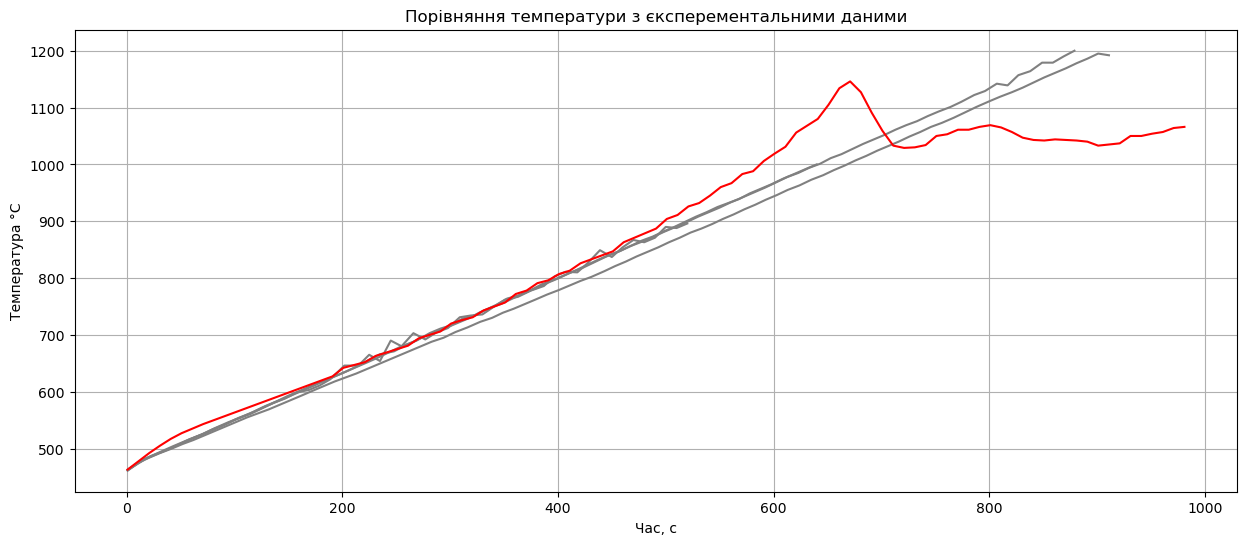

In [370]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#Temperature
sc = ax1.plot(data1200['seconds'], data1200['Pyrometer'], color='grey')
sc = ax1.plot(data1000['seconds'], data1000['Pyrometer'], color='grey')
sc = ax1.plot(data900['seconds'], data900['Pyrometer'], color='grey')
sc = ax1.plot(dataN1200['seconds'], dataN1200['Pyrometer'], color='grey')
sc = ax1.plot(newRegime['seconds'], newRegime['Pyrometer'], color='red')

ax1.set_title('Порівняння температури з єксперементальними даними')
ax1.set_xlabel('Час, с')
ax1.set_ylabel('Температура °C')
ax1.grid(True)
plt.show()

<Figure size 1500x600 with 0 Axes>

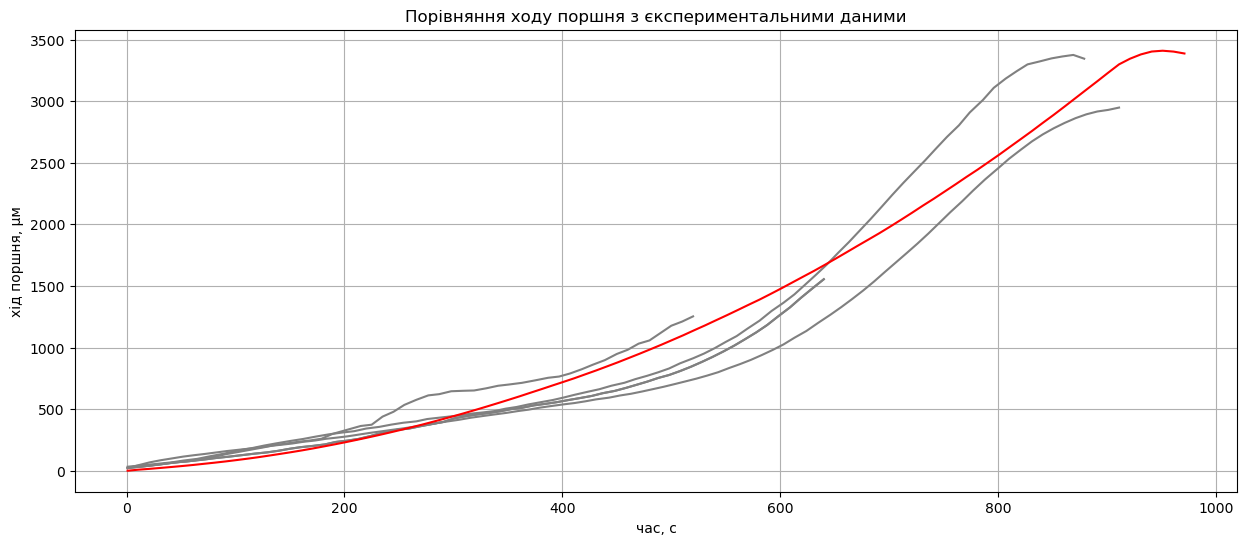

In [375]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

sc = ax1.plot(data1200['seconds'], data1200['TravelRelativeTempCorrectedShifted'], color='grey') 
#sc = ax1.plot(data1350['seconds'], data1350['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(data900['seconds'], data900['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(dataN1200['seconds'], dataN1200['TravelRelativeTempCorrectedShifted'], color='grey') 
#sc = ax1.plot(dataN1100['seconds'], dataN1100['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(data1000['seconds'], data1000['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(newRegime['seconds'], newRegime['TravelRelativeTempCorrected'], color='red') 
 
ax1.set_title('Порівняння ходу поршня з єкспериментальними даними')
ax1.set_xlabel('час, с')
ax1.set_ylabel('хід поршня, μм')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

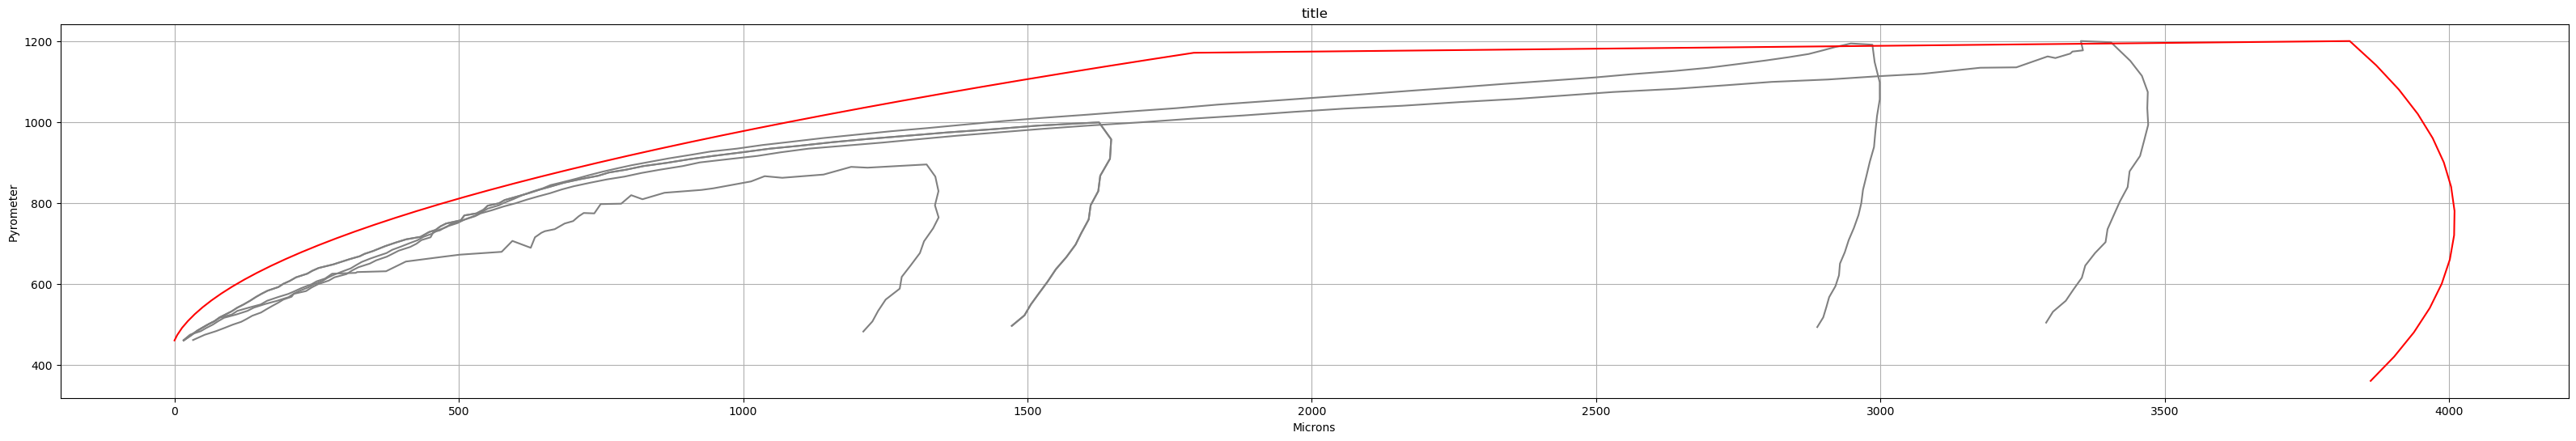

In [104]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(40, 6))

sc = ax1.plot(data1200['TravelRelativeTempCorrectedShifted'], data1200['Pyrometer'], color='grey') 
#sc = ax1.plot(data1350['Pyrometer'], data1350['Pyrometer'], color='grey') 
sc = ax1.plot(data1000['TravelRelativeTempCorrectedShifted'], data1000['Pyrometer'], color='grey') 
sc = ax1.plot(data900['TravelRelativeTempCorrectedShifted'], data900['Pyrometer'], color='grey') 
sc = ax1.plot(dataN1200['TravelRelativeTempCorrectedShifted'], dataN1200['Pyrometer'], color='grey') 
sc = ax1.plot(data1000['TravelRelativeTempCorrectedShifted'], data1000['Pyrometer'], color='grey') 
sc = ax1.plot(newRegime['TravelRelativeTempCorrected'], newRegime['Pyrometer'], color='red') 
 

ax1.set_title('title')
ax1.set_xlabel('Microns')
ax1.set_ylabel('Pyrometer')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

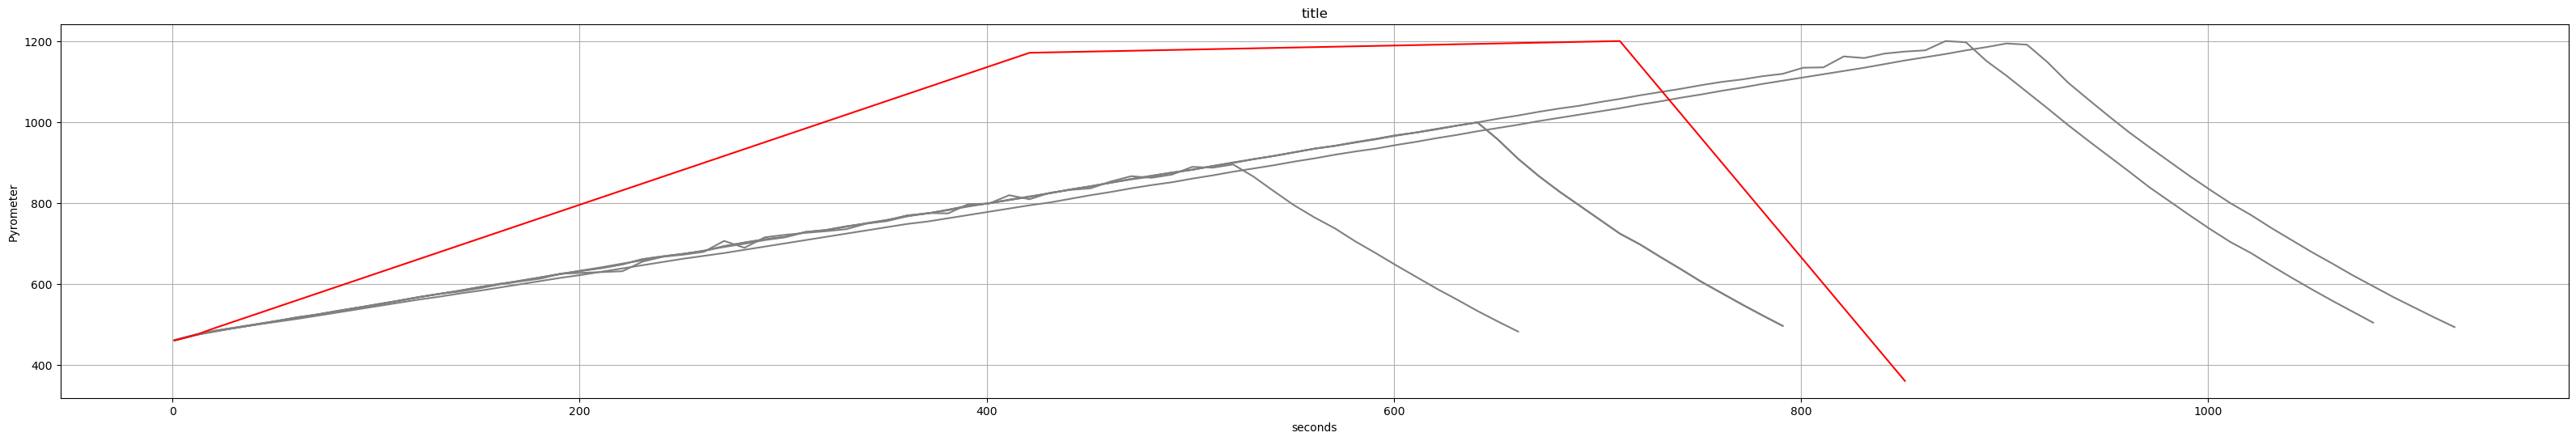

In [105]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(40, 6))

sc = ax1.plot(data1200['seconds'], data1200['Pyrometer'], color='grey') 
#sc = ax1.plot(data1350['seconds'], data1350['Pyrometer'], color='grey') 
sc = ax1.plot(data1000['seconds'], data1000['Pyrometer'], color='grey') 
sc = ax1.plot(data900['seconds'], data900['Pyrometer'], color='grey') 
sc = ax1.plot(dataN1200['seconds'], dataN1200['Pyrometer'], color='grey') 
sc = ax1.plot(data1000['seconds'], data1000['Pyrometer'], color='grey') 
#sc = ax1.plot(dataN1100['seconds'], dataN1100['Pyrometer'], color='grey') 
sc = ax1.plot(newRegime['seconds'], newRegime['Pyrometer'], color='red') 
 

ax1.set_title('title')
ax1.set_xlabel('seconds')
ax1.set_ylabel('Pyrometer')
ax1.grid(True)
plt.show()

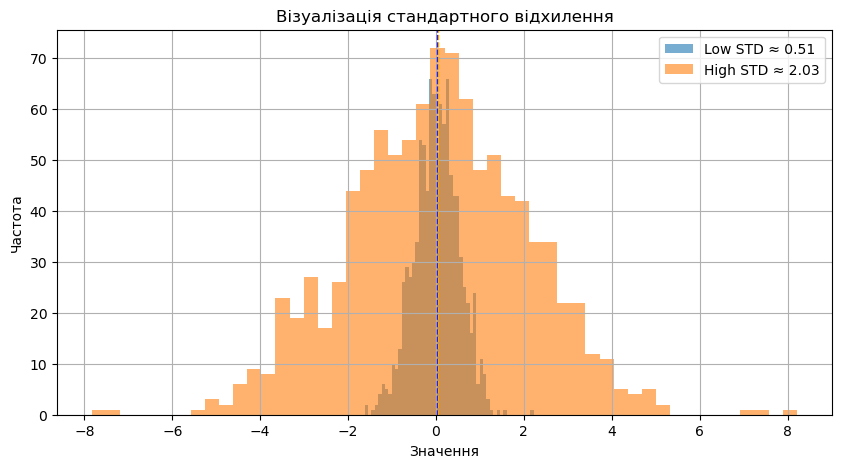